In [1]:
%pylab inline
from scipy import interpolate
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
#U = 0 # coulob repulsion
#ne = 1.6 # number of electrons per unit cell/ occupation number
# The occupation number independent part of the Hamiltonina
nk = 200
kran = linspace(-pi,pi,nk,endpoint=False)
kx,ky = meshgrid(kran,kran)
kx = kx.flatten()
ky = ky.flatten()
gamma = -(1+exp(-1j*2*kx)+exp(-1j*(kx-ky))+exp(-1j*(kx+ky)))
H0k = zeros((len(gamma),2,2),dtype=complex)


In [3]:
# this generates eigen values and eigen vectors and returns them 
def make_spectr(U,n1,n2):
    Hk = H0k.copy()
    Hk[:,0,0] = U*n1
    Hk[:,1,1] = U*n2
    return eigh(Hk)

def FD(Energy,kbt):
    return 1/(1+exp(Energy/kbt))


In [4]:
# a function that would find the new occupation number for each site, it needs to be run in a self consistency loop, this vergion can be used with fixed point f'n     
def self_consistency2(ns,U,ne,kbt):  # (U,ns,ne)
        n1_do,n2_do,n1_up,n2_up = ns  

        vals_up,vects_up = make_spectr(U,n1_do,n2_do)
        vals_do,vects_do = make_spectr(U,n1_up,n2_up)
        num_of_k_points = len(vals_up)

        
        #########################################################################
        # get new spectrum and wavefunctions
        # vals_up[ik,i] the i-th eigenvalue of up electrons at the ik-th k point
        # vecs_up[ik,site,i] the i-th wavefunction of up electrons at the ik-th k point evaluated at site "site".
 
        
        rho,eran = histogram(array([vals_up,vals_do]).flatten(),1000,density=True)
        rho = convolve(rho,hamming(10),mode='same')/5 # some additional smoothing
        NE = cumsum(rho)*diff(eran)[0]
        mu = interpolate.interp1d(NE*4,eran[:-1],fill_value="extrapolate")
        

        
        
        n1_do_new = (sum(abs(vects_do[:, 0, 0])**2*FD(vals_do[:,0]-mu(ne),kbt))+
                    sum(abs(vects_do[:, 0, 1])**2*FD(vals_do[:,1]-mu(ne),kbt)))/num_of_k_points
                                                                                                                            #i should find fermi function of energy - mu
        n2_do_new = (sum(abs(vects_do[:, 1, 0])**2*FD(vals_do[:,0]-mu(ne),kbt))+
                    sum(abs(vects_do[:, 1, 1])**2*FD(vals_do[:,1]-mu(ne),kbt)))/num_of_k_points
        
        n1_up_new = (sum(abs(vects_up[:, 0, 0])**2*FD(vals_up[:,0]-mu(ne),kbt))+
                    sum(abs(vects_up[:, 0, 1])**2*FD(vals_up[:,1]-mu(ne),kbt)))/num_of_k_points
        
        n2_up_new =  (sum(abs(vects_up[:, 1, 0])**2*FD(vals_up[:,0]-mu(ne),kbt))+
                    sum(abs(vects_up[:, 1, 1])**2*FD(vals_up[:,1]-mu(ne),kbt)))/num_of_k_points
        
        if ((n1_up > n1_do) and (n1_up_new < n1_do_new)):
            n1_up_new = n1_do_new
        if ((n2_up > n2_do) and (n2_up_new < n2_do_new)):
            n2_up_new = n2_do_new
        if ((n1_do > n1_up) and (n1_do_new < n1_up_new)):
            n1_do_new = n1_up_new
        if ((n2_do > n2_up) and (n2_do_new < n2_up_new)):
            n2_do_new = n2_up_new
            
        
        ns_new = array([n1_do_new ,n2_do_new, n1_up_new, n2_up_new])
        ns_new = (ns_new * ne)/ sum(ns_new)

        # this is a comment
       
        return ns_new - ns

In [18]:
def tot_ener(ns,U,ne,kbt):
        n1_do,n2_do,n1_up,n2_up = ns  

        vals_up,vects_up = make_spectr(U,n1_do,n2_do)
        vals_do,vects_do = make_spectr(U,n1_up,n2_up)
        num_of_k_points = len(vals_up)

        
        #########################################################################
        # get new spectrum and wavefunctions
        # vals_up[ik,i] the i-th eigenvalue of up electrons at the ik-th k point
        # vecs_up[ik,site,i] the i-th wavefunction of up electrons at the ik-th k point evaluated at site "site".
 
        
        rho,eran = histogram(array([vals_up,vals_do]).flatten(),1000,density=True)
        rho = convolve(rho,hamming(10),mode='same')/5 # some additional smoothing
        NE = cumsum(rho)*diff(eran)[0]
        mu = interpolate.interp1d(NE*4,eran[:-1],fill_value="extrapolate")
        
        energy = sum(vals_up[:,0]*FD(vals_up[:,0]-mu(ne),kbt)) +\
                 sum(vals_up[:,1]*FD(vals_up[:,1]-mu(ne),kbt)) +\
                 sum(vals_do[:,0]*FD(vals_do[:,0]-mu(ne),kbt)) +\
                 sum(vals_do[:,1]*FD(vals_do[:,1]-mu(ne),kbt)) +\
                 -(U * num_of_k_points*((n1_do*n1_up)+(n2_do*n2_up)))
        
        return energy

In [57]:
kbt =.01
# U = 1/.2
ne = 1.6
delta=.9
n1_up = (ne/4) + delta #occupation on site 1
n1_do = (ne/4) - delta
n2_up = (ne/4) - delta
n2_do = (ne/4) + delta
nvals_anti = []
for U in (1/arange(.1,.24,.01)):
     nvals_anti.append(optimize.root(self_consistency2,[n1_do,n2_do, n1_up,n2_up ], args=(U,ne,kbt),method='broyden2',options={'disp':True}))

0:  |F(x)| = 0.0530427; step 1
1:  |F(x)| = 0.0132004; step 1
2:  |F(x)| = 0.00120169; step 1
3:  |F(x)| = 3.47603e-05; step 1
4:  |F(x)| = 9.80466e-08; step 1
0:  |F(x)| = 0.064119; step 1
1:  |F(x)| = 0.0171391; step 1
2:  |F(x)| = 0.00183053; step 1
3:  |F(x)| = 6.63387e-05; step 1
4:  |F(x)| = 2.74963e-07; step 1
0:  |F(x)| = 0.0749959; step 1
1:  |F(x)| = 0.0205796; step 1
2:  |F(x)| = 0.002295; step 1
3:  |F(x)| = 8.47302e-05; step 1
4:  |F(x)| = 3.6472e-07; step 1
0:  |F(x)| = 0.0854502; step 1
1:  |F(x)| = 0.0232379; step 1
2:  |F(x)| = 0.00246441; step 1
3:  |F(x)| = 7.81882e-05; step 1
4:  |F(x)| = 2.63296e-07; step 1
0:  |F(x)| = 0.0953532; step 1
1:  |F(x)| = 0.0249974; step 1
2:  |F(x)| = 0.00234696; step 1
3:  |F(x)| = 5.6119e-05; step 1
4:  |F(x)| = 1.19439e-07; step 1
0:  |F(x)| = 0.104643; step 1
1:  |F(x)| = 0.0258762; step 1
2:  |F(x)| = 0.00203935; step 1
3:  |F(x)| = 3.32427e-05; step 1
4:  |F(x)| = 3.81681e-08; step 1
0:  |F(x)| = 0.113302; step 1
1:  |F(x)| = 0.0

In [58]:
# for i in range (1,13):
#     print(nvals_anti[i].x)

In [59]:
# for i in range (1,13):
#     print(nvals_anti[i].x)

In [60]:
tot_energy = []

for U,i in zip((1/arange(.1,.24,.01)), range(0,24)):
     tot_energy.append(tot_ener(nvals_anti[i].x,U,ne,kbt))

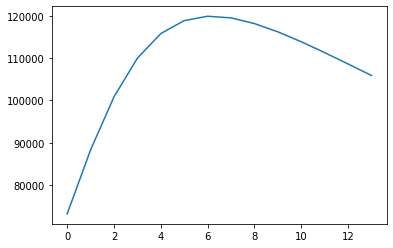

In [62]:
plot(tot_energy)

In [63]:
kbt =.01
# U = 1/.2
ne = 1.6
delta=.9
n1_up = (ne/4) + delta #occupation on site 1
n1_do = (ne/4) - delta
n2_up = (ne/4) + delta
n2_do = (ne/4) - delta
nvals_anti = []
for U in (1/arange(.1,.24,.01)):
     nvals_anti.append(optimize.root(self_consistency2,[n1_do,n2_do, n1_up,n2_up ], args=(U,ne,kbt),method='broyden2',options={'disp':True}))

0:  |F(x)| = 0.0530427; step 1
1:  |F(x)| = 0.0132004; step 1
2:  |F(x)| = 0.00120169; step 1
3:  |F(x)| = 3.47603e-05; step 1
4:  |F(x)| = 9.80466e-08; step 1
0:  |F(x)| = 0.064119; step 1
1:  |F(x)| = 0.0171391; step 1
2:  |F(x)| = 0.00183053; step 1
3:  |F(x)| = 6.63387e-05; step 1
4:  |F(x)| = 2.74963e-07; step 1
0:  |F(x)| = 0.0749959; step 1
1:  |F(x)| = 0.0205796; step 1
2:  |F(x)| = 0.002295; step 1
3:  |F(x)| = 8.47302e-05; step 1
4:  |F(x)| = 3.6472e-07; step 1
0:  |F(x)| = 0.0854502; step 1
1:  |F(x)| = 0.0232379; step 1
2:  |F(x)| = 0.00246441; step 1
3:  |F(x)| = 7.81882e-05; step 1
4:  |F(x)| = 2.63296e-07; step 1
0:  |F(x)| = 0.0953532; step 1
1:  |F(x)| = 0.0249974; step 1
2:  |F(x)| = 0.00234696; step 1
3:  |F(x)| = 5.6119e-05; step 1
4:  |F(x)| = 1.19439e-07; step 1
0:  |F(x)| = 0.104643; step 1
1:  |F(x)| = 0.0258762; step 1
2:  |F(x)| = 0.00203935; step 1
3:  |F(x)| = 3.32427e-05; step 1
4:  |F(x)| = 3.81681e-08; step 1
0:  |F(x)| = 0.113302; step 1
1:  |F(x)| = 0.0

In [64]:
tot_energy2 = []

for U,i in zip((1/arange(.1,.24,.01)), range(0,24)):
     tot_energy2.append(tot_ener(nvals_anti[i].x,U,ne,kbt))

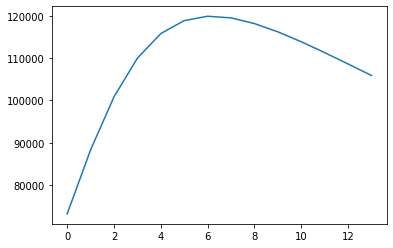

In [65]:
plot(tot_energy2)